In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
train_directory = '/content/drive/My Drive/cnn/data/train'
test_directory = '/content/drive/My Drive/cnn/data/test'


In [3]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from PIL import Image
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)



Using device: cpu


In [7]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 MB 3.3 MB/s eta 0:00:00


In [4]:

from torchvision import transforms
from torch.utils.data import DataLoader
from pathlib import Path
from PIL import Image
from sklearn.svm import SVC
import xgboost as xgb
import numpy as np
import pandas as pd
import time
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,auc,roc_curve, roc_auc_score

In [5]:
class TrainDataset(Dataset):
    def __init__(self, root_dir: Path, transform=None, device='cpu'):
        self.root = Path(root_dir)
        self.transform = transform
        self.device = device
        self.images = []
        self.labels = []
        self.class_names = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.class_names)}
        self.class_aliases = {
            'Black-grass': 'BG', 'Charlock': 'CH', 'Cleavers': 'CL',
            'Common Chickweed': 'CW', 'Common wheat': 'WH', 'Fat Hen': 'FH',
            'Loose Silky-bent': 'LS', 'Maize': 'MA', 'Scentless Mayweed': 'SC',
            'Shepherds Purse': 'SH', 'Small-flowered Cranesbill': 'SF', 'Sugar beet': 'SB'
        }
        self.original_to_alias = {
            'Black-grass': 'BG', 'Charlock': 'CH', 'Cleavers': 'CL',
            'Common Chickweed': 'CW', 'Common wheat': 'WH', 'Fat Hen': 'FH',
            'Loose Silky-bent': 'LS', 'Maize': 'MA', 'Scentless Mayweed': 'SC',
            'Shepherds Purse': 'SH', 'Small-flowered Cranesbill': 'SF', 'Sugar beet': 'SB'
        }
        for cls_name in self.class_names:
            cls_dir = self.root / cls_name
            for img_path in cls_dir.glob('*.[jp][pn]g'):
                self.images.append(img_path)
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image.to(self.device), torch.tensor(label, dtype=torch.long, device=self.device)

class TestDataset(Dataset):
    def __init__(self, root_dir: Path, transform=None, device='cuda'):
        self.root = Path(root_dir)
        self.transform = transform
        self.device = device
        self.images = sorted(list(self.root.glob('*.[jp][pn]g')))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image.to(self.device), img_path.name

def get_transform():
    return transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

def get_data_loaders(batch_size=32, val_split=0.2, device='cpu'):
    train_dir = Path('/content/drive/My Drive/cnn/data/train')
    test_dir = Path('/content/drive/My Drive/cnn/data/test')
    transform = get_transform()
    train_all_dataset = TrainDataset(train_dir, transform=transform, device=device)
    train_size = int(len(train_all_dataset) * (1 - val_split))
    val_size = len(train_all_dataset) - train_size
    train_data, val_data = random_split(train_all_dataset, [train_size, val_size])
    test_dataset = TestDataset(test_dir, transform=transform, device=device)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader, train_all_dataset.class_names, train_all_dataset.class_aliases, train_all_dataset.original_to_alias

In [6]:
import seaborn as sns
import numpy as np
from PIL import Image

def perform_eda(output_dir: Path = Path('eda_plots')):
    """Perform exploratory data analysis and save plots."""
    train_dir = Path('/content/drive/My Drive/cnn/data/train')
    output_dir.mkdir(parents=True, exist_ok=True)

    # Initialize dataset
    dataset = TrainDataset(train_dir, transform=get_transform())
    classes = dataset.class_names
    class_aliases = dataset.class_aliases

    # Validate class names
    missing_aliases = [cls for cls in classes if cls not in class_aliases]
    if missing_aliases:
        raise KeyError(f"Missing aliases for classes: {missing_aliases}")

    # Class distribution
    class_counts = [len(list((train_dir / cls).glob('*.[jp][pn]g'))) for cls in classes]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=[class_aliases[cls] for cls in classes], y=class_counts)
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.savefig(output_dir / 'class_distribution.png')
    plt.close()

    # Sample images
    plt.figure(figsize=(15, 5))
    for i, cls in enumerate(classes[:5]):
        img_path = next((train_dir / cls).glob('*.[jp][pn]g'), None)
        if img_path:
            img = Image.open(img_path).convert('RGB')
            plt.subplot(1, 5, i+1)
            plt.imshow(img)
            plt.title(class_aliases[cls])
            plt.axis('off')
    plt.savefig(output_dir / 'sample_images.png')
    plt.close()

    # Image statistics
    dimensions = []
    for cls in classes:
        for img_path in list((train_dir / cls).glob('*.[jp][pn]g'))[:50]:
            img = Image.open(img_path)
            dimensions.append(img.size)
    widths, heights = zip(*dimensions)
    plt.figure(figsize=(10, 6))
    plt.scatter(widths, heights, alpha=0.5)
    plt.title('Image Dimensions')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.savefig(output_dir / 'image_dimensions.png')
    plt.close()

    print(f"EDA plots saved in {output_dir}")
    return class_aliases

In [7]:
class CNN(nn.Module):
    def __init__(self, num_classes=12, activation='relu', filters=[16, 32, 64], strides=[1, 1, 1], input_size=(32, 32)):
        super(CNN, self).__init__()
        self.filters = filters
        self.strides = strides
        self.input_size = input_size

        # Compute output size layer by layer
        h, w = input_size
        for i, stride in enumerate(strides):
            # Conv output: (h + 2*padding - kernel_size) // stride + 1
            h = (h + 2 * 1 - 3) // stride + 1
            w = (w + 2 * 1 - 3) // stride + 1
            if i < len(strides) - 1:  # Pooling after each conv except last
                h = h // 2
                w = w // 2
        # After final conv, apply last pooling
        h = h // 2
        w = w // 2
        self.feature_map_size = (h, w)
        linear_input_size = filters[-1] * h * w

        print(f"Config: filters={filters}, strides={strides}, feature_map_size={self.feature_map_size}, linear_input_size={linear_input_size}")

        self.features = nn.Sequential(
            nn.Conv2d(3, filters[0], kernel_size=3, stride=strides[0], padding=1),
            nn.BatchNorm2d(filters[0]),
            self._get_activation(activation),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(filters[0], filters[1], kernel_size=3, stride=strides[1], padding=1),
            nn.BatchNorm2d(filters[1]),
            self._get_activation(activation),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(filters[1], filters[2], kernel_size=3, stride=strides[2], padding=1),
            nn.BatchNorm2d(filters[2]),
            self._get_activation(activation),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(linear_input_size, num_classes)
        )

    def _get_activation(self, activation):
        if activation == 'relu':
            return nn.ReLU()
        elif activation == 'leaky_relu':
            return nn.LeakyReLU(negative_slope=0.01)
        elif activation == 'elu':
            return nn.ELU()
        else:
            raise ValueError(f"Unsupported activation: {activation}")

    def forward(self, x, return_features=False):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        features = x if return_features else None
        x = self.classifier(x)
        return x if not return_features else features

In [8]:
def train_svm(X_train, y_train, X_val, y_val):
    from sklearn.svm import SVC
    svm = SVC(kernel='rbf', probability=True)
    svm.fit(X_train, y_train)
    return svm

def train_xgboost(X_train, y_train, X_val, y_val):
    from xgboost import XGBClassifier
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    xgb.fit(X_train, y_train)
    return xgb

In [13]:
def evaluate_model(model, data_loader, model_type='cnn', feature_model=None, device='cpu'):
    """Evaluate model performance and return metrics."""
    start_time = time.time()
    model.eval() if model_type == 'cnn' else None
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            y_true.extend(labels.cpu().numpy())

            if model_type == 'cnn':
                outputs = model(images)
                y_pred.extend(torch.softmax(outputs, dim=1).cpu().numpy())
            else:
                features = feature_model(images, return_features=True).cpu().numpy()
                if model_type == 'svm':
                    probs = model.predict_proba(features)
                else:  # xgboost
                    probs = model.predict_proba(features)
                y_pred.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_labels = np.argmax(y_pred, axis=1)

    metrics = {
        'accuracy': accuracy_score(y_true, y_pred_labels),
        'f1_score': f1_score(y_true, y_pred_labels, average='weighted'),
        'precision': precision_score(y_true, y_pred_labels, average='weighted', zero_division=0),
        'recall': recall_score(y_true, y_pred_labels, average='weighted'),
        'roc_auc': roc_auc_score(y_true, y_pred, multi_class='ovr'),
        'training_time': time.time() - start_time
    }
    return metrics

In [14]:
def get_features(model, data_loader, device='cpu'):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in data_loader:
            images = images.to(device)
            feats = model(images, return_features=True).cpu().numpy()
            features.append(feats)
            labels.append(lbls.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

def train_and_evaluate(train_loader, val_loader, num_classes, output_dir: Path = Path('results'), device='cpu'):
    drive.mount('/content/drive')
    output_dir = Path('/content/drive/My Drive/cnn/results')

    output_dir.mkdir(parents=True, exist_ok=True)
    activations = ['relu', 'leaky_relu', 'elu']
    filter_configs = [[16, 32, 64], [32, 64, 128]]
    stride_configs = [[1, 1, 1], [2, 1, 1]]
    results = []

    for filters in filter_configs:
        for strides in stride_configs:
            for activation in activations:
                config_str = f"{filters}_{strides}_{activation}"
                print(f"\nTraining with filters={filters}, strides={strides}, activation={activation}...")

                model = CNN(num_classes=num_classes, activation=activation, filters=filters, strides=strides).to(device)
                class_counts = [len(list((Path('/content/drive/My Drive/cnn/data/train') / cls).glob('*.[jp][pn]g'))) for cls in sorted(Path('/content/drive/My Drive/cnn/data/train').iterdir()) if cls.is_dir()]
                class_weights = torch.tensor([1.0 / c for c in class_counts], dtype=torch.float, device=device)
                criterion = nn.CrossEntropyLoss(weight=class_weights)
                optimizer = optim.Adam(model.parameters(), lr=0.0001)

                epochs = 30
                patience = 5
                best_val_loss = float('inf')
                patience_counter = 0
                history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
                y_true_all, y_score_all = [], []

                for epoch in range(epochs):
                    model.train()
                    train_loss = 0
                    train_correct = 0
                    train_total = 0
                    for images, labels in train_loader:
                        images, labels = images.to(device), labels.to(device)
                        optimizer.zero_grad()
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                        train_loss += loss.item()
                        _, predicted = torch.max(outputs, 1)
                        train_total += labels.size(0)
                        train_correct += (predicted == labels).sum().item()

                    train_loss /= len(train_loader)
                    train_acc = train_correct / train_total

                    model.eval()
                    val_loss = 0
                    y_true, y_score = [], []
                    with torch.no_grad():
                        for images, labels in val_loader:
                            images, labels = images.to(device), labels.to(device)
                            outputs = model(images)
                            val_loss += criterion(outputs, labels).item()
                            y_true.extend(labels.cpu().numpy())
                            y_score.extend(torch.softmax(outputs, dim=1).cpu().numpy())
                    val_loss /= len(val_loader)

                    val_metrics = evaluate_model(model, val_loader, model_type='cnn', device=device)
                    history['train_loss'].append(train_loss)
                    history['val_loss'].append(val_loss)
                    history['train_acc'].append(train_acc)
                    history['val_acc'].append(val_metrics['accuracy'])

                    # Compute ROC AUC for multiclass
                    y_true_all.extend(y_true)
                    y_score_all.extend(y_score)
                    y_true_np = np.array(y_true_all)
                    y_score_np = np.array(y_score_all)
                    # Per-class and micro-average AUC
                    roc_auc = roc_auc_score(y_true_np, y_score_np, multi_class='ovr', average=None)  # Per-class AUCs
                    roc_auc_micro = roc_auc_score(y_true_np, y_score_np, multi_class='ovr', average='micro')  # Micro-average AUC

                    print(f"Epoch {epoch+1}/{epochs}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Micro ROC-AUC={roc_auc_micro:.4f}")

                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        patience_counter = 0
                        torch.save(model.state_dict(), output_dir / f'best_model_{config_str}.pth')
                    else:
                        patience_counter += 1
                        if patience_counter >= patience:
                            print(f"Early stopping at epoch {epoch+1}")
                            break

                model.load_state_dict(torch.load(output_dir / f'best_model_{config_str}.pth'))

                # Final ROC plot (approximated based on micro-average AUC)
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                plt.plot(history['train_loss'], label='Train Loss')
                plt.plot(history['val_loss'], label='Val Loss')
                plt.title(f'{config_str} - Loss')
                plt.legend()
                plt.subplot(1, 3, 2)
                plt.plot(history['train_acc'], label='Train Acc')
                plt.plot(history['val_acc'], label='Val Acc')
                plt.title(f'{config_str} - Accuracy')
                plt.legend()
                plt.subplot(1, 3, 3)
                # Approximate ROC curve based on micro-average AUC
                fpr = np.linspace(0, 1, 100)
                tpr = np.interp(fpr, [0, roc_auc_micro, 1], [0, roc_auc_micro, 1])
                plt.plot(fpr, tpr, label=f'Micro-average ROC (AUC = {roc_auc_micro:.4f})')
                plt.plot([0, 1], [0, 1], 'k--')
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'{config_str} - ROC Curve')
                plt.legend(loc="lower right")
                plt.savefig(output_dir / f'training_history_{config_str}.png')
                plt.close()

                X_train, y_train = get_features(model, train_loader, device)
                X_val, y_val = get_features(model, val_loader, device)

                svm_model = train_svm(X_train, y_train, X_val, y_val)
                xgb_model = train_xgboost(X_train, y_train, X_val, y_val)

                cnn_metrics = evaluate_model(model, val_loader, model_type='cnn', device=device)
                svm_metrics = evaluate_model(svm_model, val_loader, model_type='svm', feature_model=model, device=device)
                xgb_metrics = evaluate_model(xgb_model, val_loader, model_type='xgboost', feature_model=model, device=device)

                results.append({
                    'Config': config_str,
                    'Activation': activation,
                    'Model': 'CNN + Softmax',
                    **cnn_metrics,
                    'roc_auc': roc_auc_micro
                })
                results.append({
                    'Config': config_str,
                    'Activation': activation,
                    'Model': 'CNN + SVM',
                    **svm_metrics,
                    'roc_auc': roc_auc_micro
                })
                results.append({
                    'Config': config_str,
                    'Activation': activation,
                    'Model': 'CNN + XGBoost',
                    **xgb_metrics,
                    'roc_auc': roc_auc_micro
                })

                plt.figure(figsize=(10, 4))
                plt.subplot(1, 2, 1)
                plt.plot(history['train_loss'], label='Train Loss')
                plt.plot(history['val_loss'], label='Val Loss')
                plt.title(f'{config_str} - Loss')
                plt.legend()
                plt.subplot(1, 2, 2)
                plt.plot(history['train_acc'], label='Train Acc')
                plt.plot(history['val_acc'], label='Val Acc')
                plt.title(f'{config_str} - Accuracy')
                plt.legend()
                plt.savefig(output_dir / f'training_history_{config_str}_summary.png')
                plt.close()

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_dir / 'results.csv', index=False)
    print(f"Results saved to {output_dir}")

    return results_df

In [ ]:
def main():

# Mount Drive

    output_dir = Path('/content/drive/My Drive/cnn/results')
    output_dir.mkdir(parents=True, exist_ok=True)


    print("Performing EDA...")
    class_aliases = perform_eda(output_dir)

    print("Loading data...")
    train_loader, val_loader, test_loader, classes, class_aliases, original_to_alias = get_data_loaders(device='cpu')
    num_classes = len(classes)

    print("Training and evaluating models...")
    results_df = train_and_evaluate(train_loader, val_loader, num_classes, output_dir, device='cpu')

    print("\nClass Aliases:", class_aliases)
    print("\nOriginal to Alias Mapping:", original_to_alias)
    print("\nFinal Results:")
    print(results_df)

if __name__ == '__main__':
    main()

Performing EDA...
EDA plots saved in /content/drive/My Drive/cnn/results
Loading data...
Training and evaluating models...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Training with filters=[16, 32, 64], strides=[1, 1, 1], activation=relu...
Config: filters=[16, 32, 64], strides=[1, 1, 1], feature_map_size=(4, 4), linear_input_size=1024
Epoch 1/30: Train Loss=2.4241, Train Acc=0.1416, Val Loss=2.3020, Micro ROC-AUC=0.7002
Epoch 2/30: Train Loss=2.1700, Train Acc=0.2495, Val Loss=2.0258, Micro ROC-AUC=0.7616
Epoch 3/30: Train Loss=1.8235, Train Acc=0.3947, Val Loss=1.6627, Micro ROC-AUC=0.8093
Epoch 4/30: Train Loss=1.5646, Train Acc=0.5108, Val Loss=1.4787, Micro ROC-AUC=0.8386
Epoch 5/30: Train Loss=1.4190, Train Acc=0.5439, Val Loss=1.3277, Micro ROC-AUC=0.8598
Epoch 6/30: Train Loss=1.3096, Train Acc=0.5850, Val Loss=1.2058, Micro ROC-AUC=0.8764
Epoch 7/30: Train Loss=1.2189, Train Acc=0.6158, Val L

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [02:18:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Training with filters=[16, 32, 64], strides=[1, 1, 1], activation=leaky_relu...
Config: filters=[16, 32, 64], strides=[1, 1, 1], feature_map_size=(4, 4), linear_input_size=1024
Epoch 1/30: Train Loss=2.3890, Train Acc=0.1497, Val Loss=2.2068, Micro ROC-AUC=0.7411
Epoch 2/30: Train Loss=2.0217, Train Acc=0.2958, Val Loss=1.8178, Micro ROC-AUC=0.8096
Epoch 3/30: Train Loss=1.7313, Train Acc=0.4187, Val Loss=1.6059, Micro ROC-AUC=0.8411
Epoch 4/30: Train Loss=1.5478, Train Acc=0.4971, Val Loss=1.4609, Micro ROC-AUC=0.8605
Epoch 5/30: Train Loss=1.4151, Train Acc=0.5511, Val Loss=1.3083, Micro ROC-AUC=0.8779
Epoch 6/30: Train Loss=1.2955, Train Acc=0.5895, Val Loss=1.2051, Micro ROC-AUC=0.8913
Epoch 7/30: Train Loss=1.2138, Train Acc=0.6203, Val Loss=1.1289, Micro ROC-AUC=0.9009
Epoch 8/30: Train Loss=1.1420, Train Acc=0.6450, Val Loss=1.0692, Micro ROC-AUC=0.9091
Epoch 9/30: Train Loss=1.0922, Train Acc=0.6568, Val Loss=1.0218, Micro ROC-AUC=0.9158
Epoch 10/30: Train Loss=1.0308, Train A

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:02:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Training with filters=[16, 32, 64], strides=[1, 1, 1], activation=elu...
Config: filters=[16, 32, 64], strides=[1, 1, 1], feature_map_size=(4, 4), linear_input_size=1024
Epoch 1/30: Train Loss=2.3595, Train Acc=0.1697, Val Loss=2.0909, Micro ROC-AUC=0.7937
Epoch 2/30: Train Loss=1.9418, Train Acc=0.3358, Val Loss=1.7572, Micro ROC-AUC=0.8385
Epoch 3/30: Train Loss=1.6828, Train Acc=0.4416, Val Loss=1.5667, Micro ROC-AUC=0.8619
Epoch 4/30: Train Loss=1.5316, Train Acc=0.5068, Val Loss=1.4487, Micro ROC-AUC=0.8754
Epoch 5/30: Train Loss=1.4140, Train Acc=0.5366, Val Loss=1.3262, Micro ROC-AUC=0.8874
Epoch 6/30: Train Loss=1.3144, Train Acc=0.5771, Val Loss=1.2371, Micro ROC-AUC=0.8971
Epoch 7/30: Train Loss=1.2415, Train Acc=0.6124, Val Loss=1.1729, Micro ROC-AUC=0.9053
Epoch 8/30: Train Loss=1.1832, Train Acc=0.6239, Val Loss=1.1198, Micro ROC-AUC=0.9114
Epoch 9/30: Train Loss=1.1294, Train Acc=0.6476, Val Loss=1.0886, Micro ROC-AUC=0.9158
Epoch 10/30: Train Loss=1.0567, Train Acc=0.66

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:47:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Training with filters=[16, 32, 64], strides=[2, 1, 1], activation=relu...
Config: filters=[16, 32, 64], strides=[2, 1, 1], feature_map_size=(2, 2), linear_input_size=256
Epoch 1/30: Train Loss=2.4030, Train Acc=0.1561, Val Loss=2.1629, Micro ROC-AUC=0.7795
Epoch 2/30: Train Loss=2.0419, Train Acc=0.2847, Val Loss=1.9302, Micro ROC-AUC=0.8056
Epoch 3/30: Train Loss=1.8515, Train Acc=0.3503, Val Loss=1.7673, Micro ROC-AUC=0.8285
Epoch 4/30: Train Loss=1.7193, Train Acc=0.4205, Val Loss=1.6443, Micro ROC-AUC=0.8451
Epoch 5/30: Train Loss=1.6088, Train Acc=0.4713, Val Loss=1.5173, Micro ROC-AUC=0.8597
Epoch 6/30: Train Loss=1.5116, Train Acc=0.5147, Val Loss=1.4280, Micro ROC-AUC=0.8713
Epoch 7/30: Train Loss=1.4304, Train Acc=0.5497, Val Loss=1.3714, Micro ROC-AUC=0.8803
Epoch 8/30: Train Loss=1.3754, Train Acc=0.5582, Val Loss=1.2851, Micro ROC-AUC=0.8885
Epoch 9/30: Train Loss=1.3124, Train Acc=0.5789, Val Loss=1.2606, Micro ROC-AUC=0.8947
Epoch 10/30: Train Loss=1.2650, Train Acc=0.59

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:32:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Training with filters=[16, 32, 64], strides=[2, 1, 1], activation=leaky_relu...
Config: filters=[16, 32, 64], strides=[2, 1, 1], feature_map_size=(2, 2), linear_input_size=256
Epoch 1/30: Train Loss=2.4066, Train Acc=0.1479, Val Loss=2.2104, Micro ROC-AUC=0.7556
Epoch 2/30: Train Loss=2.0851, Train Acc=0.2945, Val Loss=1.9485, Micro ROC-AUC=0.8040
Epoch 3/30: Train Loss=1.8688, Train Acc=0.3855, Val Loss=1.7553, Micro ROC-AUC=0.8291
Epoch 4/30: Train Loss=1.7118, Train Acc=0.4368, Val Loss=1.6385, Micro ROC-AUC=0.8455
Epoch 5/30: Train Loss=1.6070, Train Acc=0.4721, Val Loss=1.5401, Micro ROC-AUC=0.8581
Epoch 6/30: Train Loss=1.5211, Train Acc=0.5076, Val Loss=1.4411, Micro ROC-AUC=0.8698
Epoch 7/30: Train Loss=1.4502, Train Acc=0.5345, Val Loss=1.3614, Micro ROC-AUC=0.8798
Epoch 8/30: Train Loss=1.3631, Train Acc=0.5692, Val Loss=1.2828, Micro ROC-AUC=0.8884
Epoch 9/30: Train Loss=1.3016, Train Acc=0.5942, Val Loss=1.2482, Micro ROC-AUC=0.8952
Epoch 10/30: Train Loss=1.2489, Train Ac

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:17:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Training with filters=[16, 32, 64], strides=[2, 1, 1], activation=elu...
Config: filters=[16, 32, 64], strides=[2, 1, 1], feature_map_size=(2, 2), linear_input_size=256
Epoch 1/30: Train Loss=2.4659, Train Acc=0.1337, Val Loss=2.3437, Micro ROC-AUC=0.6595
Epoch 2/30: Train Loss=2.2474, Train Acc=0.2042, Val Loss=2.1575, Micro ROC-AUC=0.7158
Epoch 3/30: Train Loss=2.0405, Train Acc=0.3063, Val Loss=1.9345, Micro ROC-AUC=0.7603
Epoch 4/30: Train Loss=1.8538, Train Acc=0.3816, Val Loss=1.7582, Micro ROC-AUC=0.7903
Epoch 5/30: Train Loss=1.7152, Train Acc=0.4271, Val Loss=1.6704, Micro ROC-AUC=0.8109
Epoch 6/30: Train Loss=1.6206, Train Acc=0.4616, Val Loss=1.5520, Micro ROC-AUC=0.8284
Epoch 7/30: Train Loss=1.5446, Train Acc=0.4934, Val Loss=1.4725, Micro ROC-AUC=0.8424
Epoch 8/30: Train Loss=1.4654, Train Acc=0.5313, Val Loss=1.3941, Micro ROC-AUC=0.8542
Epoch 9/30: Train Loss=1.4058, Train Acc=0.5379, Val Loss=1.3487, Micro ROC-AUC=0.8638
Epoch 10/30: Train Loss=1.3506, Train Acc=0.558

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:00:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Training with filters=[32, 64, 128], strides=[1, 1, 1], activation=relu...
Config: filters=[32, 64, 128], strides=[1, 1, 1], feature_map_size=(4, 4), linear_input_size=2048
Epoch 1/30: Train Loss=2.1629, Train Acc=0.2629, Val Loss=1.7604, Micro ROC-AUC=0.8779
Epoch 2/30: Train Loss=1.5705, Train Acc=0.4861, Val Loss=1.3736, Micro ROC-AUC=0.9058
Epoch 3/30: Train Loss=1.3331, Train Acc=0.5763, Val Loss=1.2117, Micro ROC-AUC=0.9198
Epoch 4/30: Train Loss=1.1698, Train Acc=0.6258, Val Loss=1.0839, Micro ROC-AUC=0.9284
Epoch 5/30: Train Loss=1.0641, Train Acc=0.6684, Val Loss=0.9790, Micro ROC-AUC=0.9365
Epoch 6/30: Train Loss=0.9637, Train Acc=0.7039, Val Loss=0.9133, Micro ROC-AUC=0.9432
Epoch 7/30: Train Loss=0.8941, Train Acc=0.7161, Val Loss=0.8524, Micro ROC-AUC=0.9485
Epoch 8/30: Train Loss=0.8336, Train Acc=0.7400, Val Loss=0.7829, Micro ROC-AUC=0.9522
Epoch 9/30: Train Loss=0.7679, Train Acc=0.7603, Val Loss=0.7376, Micro ROC-AUC=0.9558
Epoch 10/30: Train Loss=0.7286, Train Acc=0

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:47:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Training with filters=[32, 64, 128], strides=[1, 1, 1], activation=leaky_relu...
Config: filters=[32, 64, 128], strides=[1, 1, 1], feature_map_size=(4, 4), linear_input_size=2048
Epoch 1/30: Train Loss=2.2795, Train Acc=0.2134, Val Loss=1.9629, Micro ROC-AUC=0.8474
Epoch 2/30: Train Loss=1.6967, Train Acc=0.4495, Val Loss=1.4752, Micro ROC-AUC=0.8864
Epoch 3/30: Train Loss=1.3922, Train Acc=0.5547, Val Loss=1.2610, Micro ROC-AUC=0.9084
Epoch 4/30: Train Loss=1.2259, Train Acc=0.6042, Val Loss=1.1460, Micro ROC-AUC=0.9192
Epoch 5/30: Train Loss=1.1054, Train Acc=0.6508, Val Loss=1.0507, Micro ROC-AUC=0.9269
Epoch 6/30: Train Loss=1.0175, Train Acc=0.6708, Val Loss=0.9493, Micro ROC-AUC=0.9346
Epoch 7/30: Train Loss=0.9533, Train Acc=0.7071, Val Loss=0.8977, Micro ROC-AUC=0.9406
Epoch 8/30: Train Loss=0.8791, Train Acc=0.7284, Val Loss=0.8646, Micro ROC-AUC=0.9446
Epoch 9/30: Train Loss=0.8258, Train Acc=0.7437, Val Loss=0.7960, Micro ROC-AUC=0.9486
Epoch 10/30: Train Loss=0.7717, Train

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:38:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Training with filters=[32, 64, 128], strides=[1, 1, 1], activation=elu...
Config: filters=[32, 64, 128], strides=[1, 1, 1], feature_map_size=(4, 4), linear_input_size=2048
Epoch 1/30: Train Loss=2.0741, Train Acc=0.2771, Val Loss=1.6733, Micro ROC-AUC=0.8814
Epoch 2/30: Train Loss=1.5289, Train Acc=0.4892, Val Loss=1.3654, Micro ROC-AUC=0.9053
Epoch 3/30: Train Loss=1.3170, Train Acc=0.5634, Val Loss=1.2201, Micro ROC-AUC=0.9191
Epoch 4/30: Train Loss=1.1704, Train Acc=0.6263, Val Loss=1.1027, Micro ROC-AUC=0.9286
Epoch 5/30: Train Loss=1.0723, Train Acc=0.6695, Val Loss=1.0179, Micro ROC-AUC=0.9352
Epoch 6/30: Train Loss=1.0005, Train Acc=0.6839, Val Loss=0.9260, Micro ROC-AUC=0.9410
Epoch 7/30: Train Loss=0.9201, Train Acc=0.7163, Val Loss=0.8926, Micro ROC-AUC=0.9453
Epoch 8/30: Train Loss=0.8649, Train Acc=0.7316, Val Loss=0.8645, Micro ROC-AUC=0.9484
Epoch 9/30: Train Loss=0.8107, Train Acc=0.7455, Val Loss=0.7801, Micro ROC-AUC=0.9524
Epoch 10/30: Train Loss=0.7732, Train Acc=0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:28:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Training with filters=[32, 64, 128], strides=[2, 1, 1], activation=relu...
Config: filters=[32, 64, 128], strides=[2, 1, 1], feature_map_size=(2, 2), linear_input_size=512
Epoch 1/30: Train Loss=2.2581, Train Acc=0.2179, Val Loss=1.9579, Micro ROC-AUC=0.8371
Epoch 2/30: Train Loss=1.7879, Train Acc=0.3989, Val Loss=1.6226, Micro ROC-AUC=0.8688
Epoch 3/30: Train Loss=1.5480, Train Acc=0.5074, Val Loss=1.4201, Micro ROC-AUC=0.8851
Epoch 4/30: Train Loss=1.3876, Train Acc=0.5534, Val Loss=1.3001, Micro ROC-AUC=0.9001
Epoch 5/30: Train Loss=1.2738, Train Acc=0.5947, Val Loss=1.1828, Micro ROC-AUC=0.9104
Epoch 6/30: Train Loss=1.1760, Train Acc=0.6276, Val Loss=1.1282, Micro ROC-AUC=0.9186
Epoch 7/30: Train Loss=1.1104, Train Acc=0.6532, Val Loss=1.0760, Micro ROC-AUC=0.9243
Epoch 8/30: Train Loss=1.0391, Train Acc=0.6797, Val Loss=1.0019, Micro ROC-AUC=0.9299
Epoch 9/30: Train Loss=0.9818, Train Acc=0.6966, Val Loss=0.9751, Micro ROC-AUC=0.9339
Epoch 10/30: Train Loss=0.9342, Train Acc=0.

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:17:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Training with filters=[32, 64, 128], strides=[2, 1, 1], activation=leaky_relu...
Config: filters=[32, 64, 128], strides=[2, 1, 1], feature_map_size=(2, 2), linear_input_size=512
Epoch 1/30: Train Loss=2.3385, Train Acc=0.1703, Val Loss=2.0753, Micro ROC-AUC=0.7994
Epoch 2/30: Train Loss=1.8775, Train Acc=0.3616, Val Loss=1.6788, Micro ROC-AUC=0.8447
Epoch 3/30: Train Loss=1.5781, Train Acc=0.4732, Val Loss=1.4677, Micro ROC-AUC=0.8721
Epoch 4/30: Train Loss=1.4168, Train Acc=0.5434, Val Loss=1.3632, Micro ROC-AUC=0.8857
Epoch 5/30: Train Loss=1.2920, Train Acc=0.5889, Val Loss=1.2656, Micro ROC-AUC=0.8958
Epoch 6/30: Train Loss=1.2155, Train Acc=0.6092, Val Loss=1.1311, Micro ROC-AUC=0.9061
Epoch 7/30: Train Loss=1.1314, Train Acc=0.6337, Val Loss=1.0900, Micro ROC-AUC=0.9137
Epoch 8/30: Train Loss=1.0676, Train Acc=0.6589, Val Loss=1.0274, Micro ROC-AUC=0.9204
Epoch 9/30: Train Loss=1.0150, Train Acc=0.6789, Val Loss=1.0055, Micro ROC-AUC=0.9254
Epoch 10/30: Train Loss=0.9565, Train 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:01:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Training with filters=[32, 64, 128], strides=[2, 1, 1], activation=elu...
Config: filters=[32, 64, 128], strides=[2, 1, 1], feature_map_size=(2, 2), linear_input_size=512
Epoch 1/30: Train Loss=2.2474, Train Acc=0.2047, Val Loss=1.9963, Micro ROC-AUC=0.8092
Epoch 2/30: Train Loss=1.8301, Train Acc=0.3771, Val Loss=1.6517, Micro ROC-AUC=0.8433
Epoch 3/30: Train Loss=1.5868, Train Acc=0.4647, Val Loss=1.4698, Micro ROC-AUC=0.8679
Epoch 4/30: Train Loss=1.4428, Train Acc=0.5226, Val Loss=1.3600, Micro ROC-AUC=0.8827
Epoch 5/30: Train Loss=1.3268, Train Acc=0.5700, Val Loss=1.2670, Micro ROC-AUC=0.8949
Epoch 6/30: Train Loss=1.2312, Train Acc=0.6087, Val Loss=1.2018, Micro ROC-AUC=0.9036
Epoch 7/30: Train Loss=1.1694, Train Acc=0.6284, Val Loss=1.1242, Micro ROC-AUC=0.9105
Epoch 8/30: Train Loss=1.0990, Train Acc=0.6495, Val Loss=1.0663, Micro ROC-AUC=0.9172
Epoch 9/30: Train Loss=1.0440, Train Acc=0.6639, Val Loss=1.0122, Micro ROC-AUC=0.9227
Epoch 10/30: Train Loss=0.9831, Train Acc=0.6

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:45:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Results saved to /content/drive/My Drive/cnn/results

Class Aliases: {'Black-grass': 'BG', 'Charlock': 'CH', 'Cleavers': 'CL', 'Common Chickweed': 'CW', 'Common wheat': 'WH', 'Fat Hen': 'FH', 'Loose Silky-bent': 'LS', 'Maize': 'MA', 'Scentless Mayweed': 'SC', 'Shepherds Purse': 'SH', 'Small-flowered Cranesbill': 'SF', 'Sugar beet': 'SB'}

Original to Alias Mapping: {'Black-grass': 'BG', 'Charlock': 'CH', 'Cleavers': 'CL', 'Common Chickweed': 'CW', 'Common wheat': 'WH', 'Fat Hen': 'FH', 'Loose Silky-bent': 'LS', 'Maize': 'MA', 'Scentless Mayweed': 'SC', 'Shepherds Purse': 'SH', 'Small-flowered Cranesbill': 'SF', 'Sugar beet': 'SB'}

Final Results:
                                Config  Activation          Model  accuracy  \
0          [16, 32, 64]_[1, 1, 1]_relu        relu  CNN + Softmax  0.827368   
1          [16, 32, 64]_[1, 1, 1]_relu        relu      CNN + SVM  0.863158   
2          [16, 32, 64]_[1, 1, 1]_relu        relu  CNN + XGBoost  0.812632   
3    [16, 32, 64]_[1, 1, 1]_l

Using device: cpu
Config: filters=[32, 64, 128], strides=[1, 1, 1], feature_map_size=(4, 4), linear_input_size=2048
y_true: [np.int64(6), np.int64(1), np.int64(4), np.int64(4), np.int64(3), np.int64(4), np.int64(10), np.int64(6), np.int64(9), np.int64(2)]
y_true length: 950
y_score shape: (950, 12)


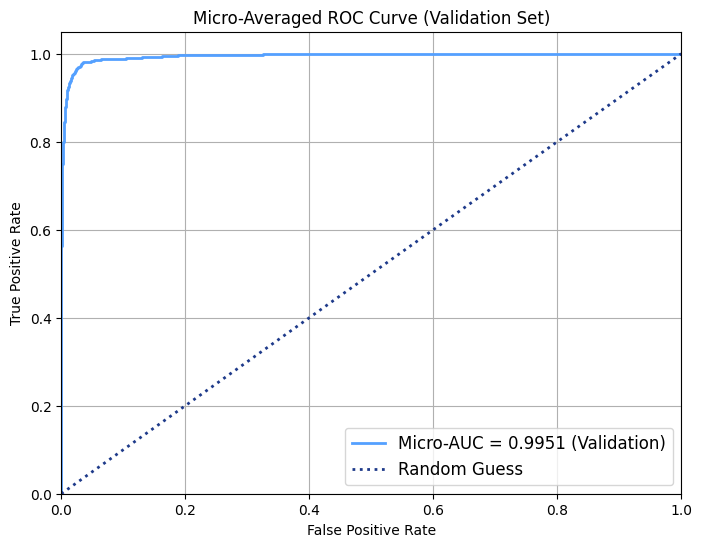

In [13]:
import torch


from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load data loaders, ensuring validation data has labels
train_loader, val_loader, test_loader, class_names, class_aliases, original_to_alias = get_data_loaders(device=device)
model = CNN(filters=[32, 64, 128], strides=[1, 1, 1]) # Define your model architecture
model.load_state_dict(torch.load('/content/drive/My Drive/cnn/results/best_model_[32, 64, 128]_[1, 1, 1]_relu.pth', map_location=device))
model = model.to(device)
model.eval()

y_true = []
y_score = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_true.extend(labels.cpu().numpy())  # Labels are tensors from TrainDataset
        if isinstance(outputs, (tuple, list)):
            outputs = outputs[0]
        y_score.extend(torch.softmax(outputs, dim=1).cpu().numpy())

print("y_true:", y_true[:10])
print("y_true length:", len(y_true))
print("y_score shape:", np.array(y_score).shape)

# Generate ROC curve
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Ensure y_true and y_score are numpy arrays
y_true = np.array(y_true)
y_score = np.array(y_score)

# Binarize the labels for multi-class ROC
y_true_binarized = label_binarize(y_true, classes=np.arange(len(class_names)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(y_true_binarized.ravel(), y_score.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)


plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, color='#54A0FF', lw=2, label=f'Micro-AUC = {roc_auc_micro:.4f} (Validation)')
plt.plot([0, 1], [0, 1], color='#1E3A8A', lw=2, linestyle=':', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Averaged ROC Curve (Validation Set)')
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.savefig('roc_curves_validation.png', dpi=300, bbox_inches='tight')
plt.show()

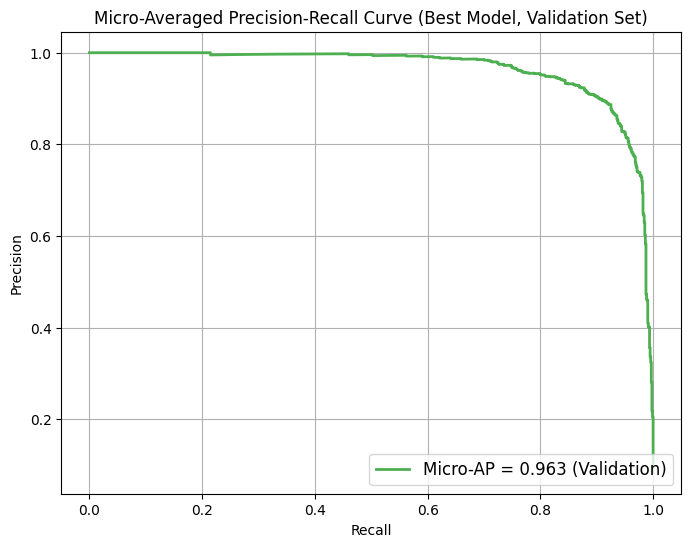

In [15]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute micro-average precision-recall curve and area
precision_micro, recall_micro, _ = precision_recall_curve(y_true_binarized.ravel(), y_score.ravel())
average_precision_micro = average_precision_score(y_true_binarized, y_score, average="micro")

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall_micro, precision_micro, color='#4CAF50', lw=2, label=f'Micro-AP = {average_precision_micro:.3f} (Validation)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Micro-Averaged Precision-Recall Curve (Best Model, Validation Set)')
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.savefig('pr_curves_validation_best.png', dpi=300, bbox_inches='tight')
plt.show()

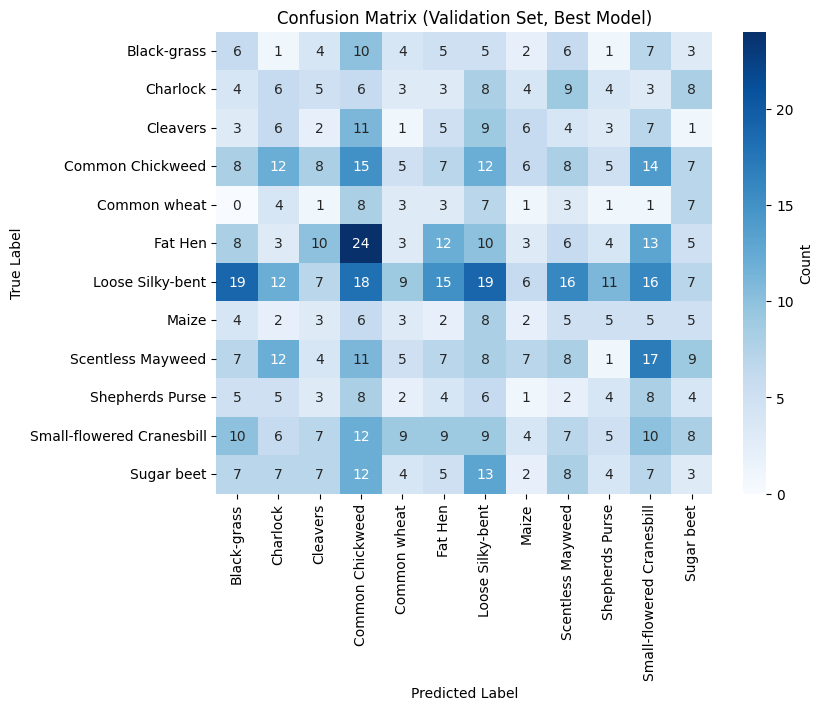

In [16]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix (assuming y_pred is from np.argmax(y_score))
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Validation Set, Best Model)')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

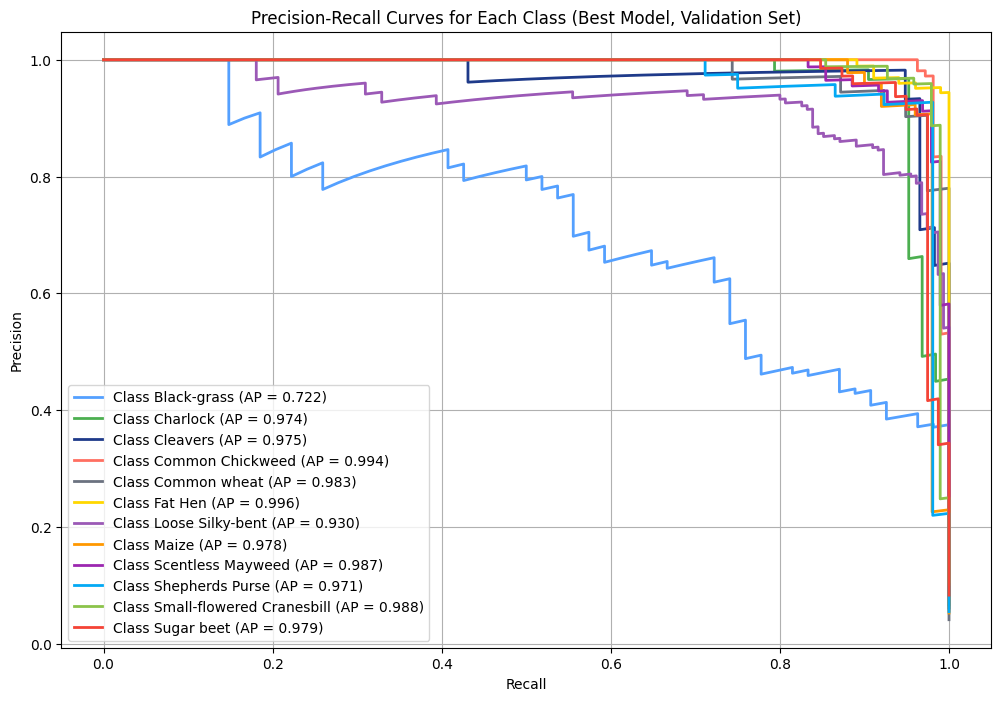

In [19]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(12, 8))
colors = ['#54A0FF', '#4CAF50', '#1E3A8A', '#FF6F61', '#6B7280', '#FFD700', '#9B59B6', '#FF9800', '#9C27B0', '#03A9F4', '#8BC34A', '#F44336']
for i, color in zip(range(len(class_names)), colors):
    precision, recall, _ = precision_recall_curve(y_true_binarized[:, i], y_score[:, i])
    ap = average_precision_score(y_true_binarized[:, i], y_score[:, i])
    plt.plot(recall, precision, color=color, lw=2, label=f'Class {class_names[i]} (AP = {ap:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Class (Best Model, Validation Set)')
plt.legend(loc='best', fontsize=10)
plt.grid(True)
plt.savefig('pr_curves_per_class.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
print(len(class_names))

12
